## A Bayesian parameter inference of a **Simple hydro-response model**.
>**1. Loading simulation data**
    - This section show how to load simulation data from the disk. Anyone who wish to use the code to do another Bayesian analysis for relativistic heavy ion collision should do minor change to this section that suits their model and simulation data.
            --Python modules used
                - pandas
    
>**2. Preprocessing of the simulation data**
    - We perform a scaling transform and then a Principal Component Analysis (PCA) to reduce the dimensions of the data. We keep only 10 PCs for the next steps of the analysis.
            --Python modules used
                - numpy, sklearn
                
>**3. Load priors and experimental data**
    - We use uniform priors and load the bounds for the priors from a file saved on the disk. Relevant experimental data is also loaded from the disk. A new analysis with new data will have to make changes to this part of the code. 
            --Python modules used
                - pandas

>**4. Building Emulators**
    - Since the simulations are computationally expensive we need surrogate models that can be trained on limited number of points and then used to predict the simulation output at any given point. For this purpose we use Gaussian Processes and they also give the uncertainty in the prediction which is very crucial for the reliability of the Bayesian parameter extraction method. 
            --Python modules used
                - sklearn Gaussian Processors, numpy
                
>**5. Bayesian Parameter Estimation**
    - This is where everything comes together and magic happens! The Bayes theorem is used to find the posterior of the model parameters using the experimental data.
            --Python modules used
                - pandas, numpy, seaborn

In [1]:
name="Simple_bayes"

In [2]:
import subprocess
from multiprocessing import Pool
from multiprocessing import cpu_count
import os
import pickle
import math

import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor as gpr
from sklearn.gaussian_process import kernels as krnl

import scipy.stats as st
from scipy import optimize
from scipy.linalg import lapack

from pyDOE import lhs
import emcee # 3.0
import ptemcee
import h5py

sns.set("notebook")

#Saved emulator name
EMU='simple_emu.dat'
# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "DataFiles/"

### A toy model to demonstrate basic ideas of bulk medium calibraiton

#### Bulk models:
1. Initial condition: initial condition energy density, geometry, $e(x_\perp)$
2. Dynamical models (JETSCAPE):
   * Preequilbirum evolution
   * Hydrodynamic evolution (take $\eta/s(T), \zeta/s(T)$ as input)
   * Particlziation + hadronic scatterings / decays
   
Dynamical evolution translates initial condition into final-state observables such as
   * particle multiplicity
   * anisotropy flows and correlations
   * ...

In this exercise, we will use pregenerated TRENTo results of $E_T$, $\langle e\rangle$, and $\epsilon_2$ v.s. Centrality to represent an initial condition. Then, instead of using the full JETSCAPE bulk simulation, we will use a toy model that will demonstrate a few basic but important feautre of the full analysis.


#### Set up the toy problem

##### Target quantity $\eta/s(T)$: 
We would like to extract the temperature-dependent shear viscosity that is parameterized as 
$$\frac{\eta}{s}(T) = \color{red}{\left(\frac{\eta}{s}\right)_A } + (T/{\rm GeV}-0.15) \color{red}{\left(\frac{\eta}{s}\right)_B }$$


Suppose any initional condition model has provided as $dE_T/d\eta_s$ ($E_T$ for short), $\frac{de}{\tau_0d\eta_s dx^2}$ ($e_0$ for short), and $\epsilon_2$ v.s. centraliy.

We assume they are mapped to the final-state charged particle multiplictiy and elliptic flow by the following response:

$$
N_{\rm ch} = {\color{red} n} \times E_T \times (1 + (\eta/s)_{\rm eff})\\
v_2 = \epsilon_2 \times \exp\left\{-\frac{(\eta/s)_{\rm eff}}{N^{1/3}_{\rm ch}/60}\right\}
$$

Here, let's assume the damping effective on $v_2$ due to viscosity is only sensitive to a time-averaged effective (https://arxiv.org/abs/1912.06287) $$(\eta/s)_{\rm eff} = \frac{\int_{T_c}^{T_0} T^{p} \left(\eta/s\right)_T dT }{\int_{T_c}^{T_0} T^{p} dT } $$


In [3]:
def Load_Initial_Conditions(Run_TRENTo=False, Nevents=10000):
    if not Run_TRENTo:
        print("Loading pregenerted collision geometry information")
        cen, cenL, cenU, ET, ed, e2 = np.loadtxt(DATA_ID+"/Geometry_info.dat").T
    else:
        TRENTo_dtype=[('idx',np.int,1), ('b', np.float,1),
              ('npart', np.int,1), ('area', np.float, 1), 
              ('ET', np.float,1),
              ('e2', np.float,1), ('e3', np.float,1),  
              ('e4', np.float,1), ('e5', np.float,1),  
             ]
        print("Generating trento Pb+Pb with default params")
        proc = subprocess.run(
                ['trento', 'Pb','Pb', '{:d}'.format(Nevents)],
                stdout=subprocess.PIPE
            )
        results = np.empty(Nevents, dtype=TRENTo_dtype)
        for l, it in zip(proc.stdout.splitlines(), results):
            for dtype, value in zip(TRENTo_dtype, l.split()):
                it[dtype[0]] = value
        # sort by ET
        sorted_events = results[np.argsort(results['ET'])[::-1]]
        cenbin = np.array([0,5,10,20,30,40,50,60,70]) 
        cen = (cenbin[1:] + cenbin[:-1])/2.
        Ibin = (cenbin*Nevents/100.).astype(int)
        ET = np.array([sorted_events['ET'][il:ih].mean() for il, ih in zip(Ibin[:-1], Ibin[1:]) ])
        Area = np.array([sorted_events['area'][il:ih].mean() for il, ih in zip(Ibin[:-1], Ibin[1:]) ])
        e2 = np.array([sorted_events['e2'][il:ih].mean() for il, ih in zip(Ibin[:-1], Ibin[1:]) ])
        ed = ET/Area/5.076**2/20
        with open(DATA_ID+"Geometry_info.dat", 'w') as f:
            f.write("#cen\tcenL\tcenU\tET\te2\te3\n")
            for ic, icl, icu, iet, ied, ie2 in zip(cen, cenbin[:-1], cenbin[1:], ET, ed, e2):
                f.write(("{:1.1f}\t"*3+"{:1.4f}\t"*3+'\n').format(ic,icl,icu,iet,ied, ie2))

    return np.array([cen, ET, ed, e2])

In [4]:
#cen, ET, ed, e2 = Load_Initial_Conditions(Run_TRENTo=True)
cen, ET, ed, e2 = Load_Initial_Conditions(Run_TRENTo=False)

Loading pregenerted collision geometry information


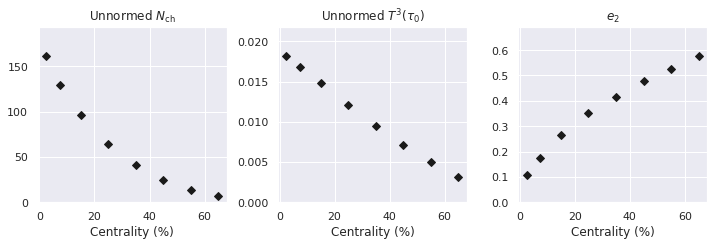

In [5]:
fig, axes = plt.subplots(1,3, figsize=(10,3.5), sharex=True)
for ax,y,name in zip(axes, 
                    [ET, ed, e2],
                    [r"Unnormed $N_{\rm ch}$", r"Unnormed $T^3(\tau_0)$", r"$e_2$"]):
    ax.plot(cen, y, 'kD')
    ax.set_title(name)
    ax.set_xlabel("Centrality (%)")
    ax.set_ylim(ymin=0, ymax=y.max()*1.2)
plt.tight_layout(True)

In [6]:
# Toy model of a hydro-like repsonse to eccentricity
from scipy.integrate import quad


def etas(T, params):
    etasA, etasB, etasC, etasD = params
    res = etasA + etasB*(T-etasD)*(T>etasD) + etasC*(etasD-T)*(T<etasD)
    if not hasattr(T, "__len__"):
        return np.max([res, 0.])
    else:
        res[res<0.] = 0.
        return res

"""
def etas(T, params):
    etasA, etasB = params
    res = etasA + etasB*(T-0.15)
    if not hasattr(T, "__len__"):
        return np.max([res, 0.])
    else:
        res[res<0.] = 0.
        return res
    

def etas(T, params):
    etas = params[0]
    return etas * np.ones_like(T)
"""
Tpower = -3

def etas_eff(Tmax, params):
    N = quad(lambda T: T**Tpower * etas(T, params), 0.13, Tmax)[0]
    D = quad(lambda T: T**Tpower, 0.13, Tmax)[0]
    return N/D

def ToyModel(params):
    norm = params[0]
    etas_avg = np.array([etas_eff((norm*ied)**(1./3.), params[1:]) for ied in ed])
    mult = norm * ET * (1. + etas_avg)
    v2 = e2 * np.exp(- 50 * etas_avg / (mult)**.3333 ) 
    return mult, v2

### 1. Model data

#### option 1: load from pregenerated data files
#### option 2: run the simple model

In [7]:
if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

In [177]:
# Design points
#Model parameter names in Latex compatble form
Ndesign = 100
read_design_from_file = False
if read_design_from_file:
    design_df = pd.read_csv(data_path('designForSimpleModel'))
    design = design_df.values
    ranges_df = pd.read_csv(data_path('designRangeForSimpleModel'))
    ranges = ranges_df.values
    print(f'Load design from file. Design shape is {design.shape}')
else:
    model_param_dsgn = ['$N$', '$\eta/s(A)$', '$\eta/s(B)$', '$\eta/s(C)$', '$\eta/s(D)$']
    ranges = np.array([
        [6,15],[.02, 0.2],[-1,4],[0,10],[0.1, 0.35]
    ])
    ranges_df = pd.DataFrame(ranges, columns=['min','max'], index=model_param_dsgn)
    ranges_df.to_csv(data_path('designRangeForSimpleModel'), index=False)
    
    unit = lhs(ranges.shape[0], samples=Ndesign, criterion='maximin')
    design = unit*(ranges[:,1]-ranges[:,0]) + ranges[:,0]
    design_df = pd.DataFrame(design, columns=model_param_dsgn)
    design_df.to_csv(data_path('designForSimpleModel'), index=False)
design_max = ranges[:,1]
design_min = ranges[:,0]
design_ptp = design_max - design_min
Xdim = ranges.shape[0]

In [178]:
ranges_df.head() 

,min,max
$N$,6.00,15.00
$\eta/s(A)$,0.02,0.20
$\eta/s(B)$,-1.00,4.00
$\eta/s(C)$,0.00,10.00
$\eta/s(D)$,0.10,0.35


In [179]:
design_df.head() 

,$N$,$\eta/s(A)$,$\eta/s(B)$,$\eta/s(C)$,$\eta/s(D)$
0,14.812959,0.129185,3.621012,0.588236,0.166844
1,11.816548,0.029470,3.557720,4.814574,0.269340
2,9.741302,0.046330,1.508122,5.899506,0.326726
3,12.960314,0.193729,-0.139231,9.183265,0.180442
4,6.121447,0.035178,1.158081,1.516017,0.189646


Text(0, 0.5, '$\\eta/s(A)$')

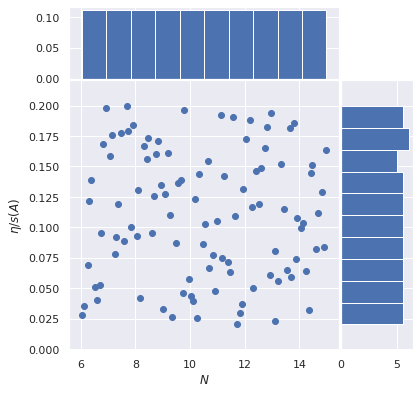

In [183]:
# check the design for the ith and jth parameters
i,j = 0,1

left, width = 0.1, 0.75
bottom, height = 0.1, 0.75
spacing = 0.005
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(5, 5))
ax = fig.add_axes(rect_scatter)
ax1 = fig.add_axes(rect_histx, sharex=ax)
ax2 = fig.add_axes(rect_histy, sharey=ax)
ax1.tick_params(axis="x", labelbottom=False)
ax2.tick_params(axis="y", labelleft=False)

ax.scatter(design[:,i], design[:,j])
ax1.hist(design[:,i], density=True)
ax2.hist(design[:,j], orientation='horizontal', density=True)
ax.set_xlabel(model_param_dsgn[i])
ax.set_ylabel(model_param_dsgn[j])

In [184]:
#Simulation outputs at the design points
simulation = np.array([np.concatenate(ToyModel(param)) for param in design])

Design shape:  (100, 5)
Model output shape:  (100, 16)


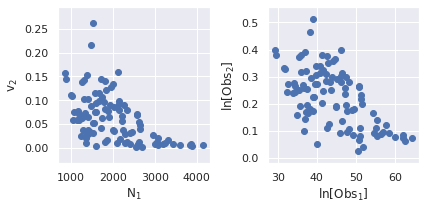

In [185]:
# Check if the observables forms joint normal distribution (apprimately)
# If not, we should worry (as it is hard for GP/PCA to dealt with highly-non-linearly correlations) and make transformations

X = np.copy(design)#design.values
Y = np.copy(simulation)#simulation.values
Ydim = Y.shape[1]

print( "Design shape: ", X.shape )
print( "Model output shape: ", Y.shape )

Nc = len(cen)

id1,  id2 = 1, 10
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(6,3))
ax1.scatter(Y[:,id1], Y[:,id2])
ax1.set_xlabel(r"${\rm N}_1$")
ax1.set_ylabel(r"${\rm v}_2$")
Y = Y**.5
ax2.scatter(Y[:,id1], Y[:,id2])
ax2.set_xlabel(r"$\ln[{\rm Obs}_1]$")
ax2.set_ylabel(r"$\ln[{\rm Obs}_2]$")
plt.tight_layout(True)

# >>> Compare the effect w/ and w/o the transformation

### 2. Preprocessing of simulation data.

In [186]:
#Scaling the data to be zero mean and unit variance for each feature
SS  =  StandardScaler(copy=True)

In [187]:
#Singular Value decomposition
u, s, vh = np.linalg.svd(SS.fit_transform(Y), full_matrices=True)
print(f'shape of u {u.shape} shape of s {s.shape} shape of vh {vh.shape}')

shape of u (100, 100) shape of s (16,) shape of vh (16, 16)


In [188]:
#whiten and project data to principal component axis (only keeping first 10 PCs)
Npc = 3
pc_tf_data=u[:,0:Npc] * math.sqrt(u.shape[0]-1)
#Scale Transformation from PC space to original data space
inverse_tf_matrix= np.diag(s[0:Npc]) @ vh[0:Npc,:] * SS.scale_.reshape(1,Ydim)/ math.sqrt(u.shape[0]-1)

#### A check for consistency of our explicit PCA calculation from scikit-learn library PCA module.
We need access to the scaling transform involved in PCA for uncertainty propagation of emulator predictions. And also it is needed to find the truncation error of keeping only the dominant PC of data. So we prefer to rather use explicit PCA using SVD rather than using the scikit-learn PCA module

##### Check the PC transform (optional)

In [189]:
# White actually multiply each PC by sqrt of n_samples-1
pca_analysis = PCA(n_components=Npc, whiten=True, svd_solver='auto')
pca_analysis.fit(SS.fit_transform(Y))
scikit_pc_tf_data=pca_analysis.transform(SS.fit_transform(Y))
print(f'Transformed data shape {scikit_pc_tf_data.shape}')

Transformed data shape (100, 3)


In [190]:
#The sign difference is OK. That is why we only compare abs value of transformed Data
#explanation https://stackoverflow.com/questions/44765682/in-sklearn-decomposition-pca-why-are-components-negative
print(f'Print True if the transformed data is same from SVD aproach and scikit\
learn PCA methods\n{np.allclose(np.abs(scikit_pc_tf_data),np.abs(pc_tf_data))}')

Print True if the transformed data is same from SVD aproach and scikitlearn PCA methods
True


##### Check inverse PC transform

In [191]:
scikit_inverse_tf_data=SS.inverse_transform(pca_analysis.inverse_transform(scikit_pc_tf_data))
inverse_tf_data=pc_tf_data @ inverse_tf_matrix + np.repeat([SS.mean_],repeats=Ndesign, axis=0)
print(f'Print True if the inverse transformed data is same from SVD aproach and scikit\
learn PCA methods\n{np.allclose(scikit_inverse_tf_data,inverse_tf_data)}')

Print True if the inverse transformed data is same from SVD aproach and scikitlearn PCA methods
True


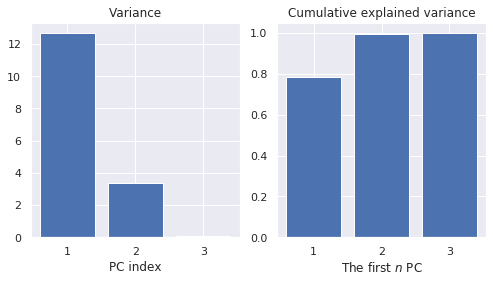

In [192]:
# print the explained raito of variance
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(7,4))
importance = pca_analysis.explained_variance_
cumulateive_importance = np.cumsum(importance)/np.sum(importance)
idx = np.arange(1,1+len(importance))
ax1.bar(idx,importance)
ax1.set_xlabel("PC index")
ax1.set_title("Variance")
ax2.bar(idx,cumulateive_importance)
ax2.set_xlabel(r"The first $n$ PC")
ax2.set_title("Cumulative explained variance")
plt.tight_layout(True)
# sum_1^nth var / total

### 3. A pseudo-experimental data

In [195]:
# Pseudo data generated with "true" parameters
true_values = np.array([9.0, 0.1, 1, 4, 0.2])
stat_level = 0.05
# true_values = np.array([9.0, 0.1])
# true_values = np.array([9.0, 0.1, 0.6])
Mult, v2 = ToyModel(true_values)

y_exp = np.concatenate([Mult, v2])
y_exp *= (1. + np.random.normal(0,stat_level,len(y_exp)))
y_stat = y_exp * stat_level
y_exp_variance = np.diag(y_stat**2)

Ydim = len(y_exp)

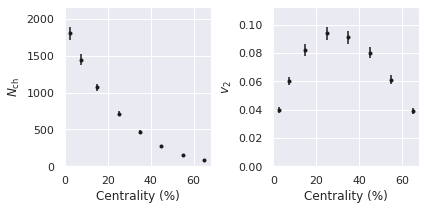

In [196]:
fig, axes = plt.subplots(1,2, figsize=(6,3), sharex=True)
for ax,y,name in zip(axes, 
                    [Mult, v2],
                    [r"$N_{\rm ch}$", r"$v_2$"]):
    ax.errorbar(cen, y, yerr=y*stat_level, fmt='k.')
    ax.set_ylabel(name)
    ax.set_xlabel("Centrality (%)")
    ax.set_ylim(ymin=0, ymax=y.max()*1.2)
plt.tight_layout(True)

### 4. Building emulators

In [197]:
import time
overide = True
if (os.path.exists(data_path(EMU))) and (overide==False):
    print('Saved emulators exists and overide is prohibited')
    with open(data_path(EMU),"rb") as f:
        Emulators=pickle.load(f)
else:
    Emulators=[]
    for i in range(0,Npc):
        start_time = time.time()
        kernel=1*krnl.RBF(length_scale=design_ptp,
                          length_scale_bounds=np.outer(design_ptp, (1e-2, 1e2)))\
               + krnl.WhiteKernel(noise_level=.1, 
                                  noise_level_bounds=(1e-2, 1e2))
        GPR=gpr(kernel=kernel,n_restarts_optimizer=5) # >>> check alpha
        GPR.fit(design, pc_tf_data[:,i].reshape(-1,1))
        print(f'GPR score is {GPR.score(design,pc_tf_data[:,i])} \n')
        #print(f'GPR log_marginal likelihood {GPR.log_marginal_likelihood()} \n')
        print("--- %s seconds ---" % (time.time() - start_time))
        Emulators.append(GPR)

if (overide==True) or not (os.path.exists(data_path(EMU))):
    with open(data_path(EMU),"wb") as f:
        pickle.dump(Emulators,f)
        
# >>> let people check the score!

GPR score is 0.9969052470877886 

--- 0.4659881591796875 seconds ---
GPR score is 0.9974698892614696 

--- 0.29363346099853516 seconds ---
GPR score is 0.9984344507143454 

--- 0.5181536674499512 seconds ---


In [198]:
def predict_observables(model_parameters):
    """Predicts the observables for any model parameter value using the trained emulators.
    
    Parameters
    ----------
    Theta_input : Model parameter values. Should be an 1D array of 17 model parametrs.
    Return
    ------
    Mean value and full error covaraiance matrix of the prediction is returened. """
    
    mean=[]
    variance=[]
    theta=np.array(model_parameters).flatten()
    
    if len(theta)!=Xdim:
        raise TypeError('The input model_parameters array does not have the right dimensions')
    else: 
        theta=np.array(theta).reshape(1,Xdim)
        for i in range(0,Npc):
            mn,std=Emulators[i].predict(theta,return_std=True)
            mean.append(mn)
            variance.append(std**2)
    mean=np.array(mean).reshape(1,-1)
    inverse_transformed_mean=mean @ inverse_tf_matrix + np.array(SS.mean_).reshape(1,-1)
    new_mean = inverse_transformed_mean**2
    
    variance_matrix=np.diag(np.array(variance).flatten())
    A_p = np.abs(inverse_tf_matrix)
    inverse_transformed_variance = np.einsum('ik,kl,lj-> ij', A_p.T, variance_matrix, A_p, optimize=False)
    new_variance = inverse_transformed_variance * np.outer(2.*new_mean[0]/inverse_transformed_mean[0], 
                                                           2.*new_mean[0]/inverse_transformed_mean[0])
    return new_mean, new_variance

## Emulator validation

Before applying the above model predictor based on PCA+GP, it is impertaive to validate its performance.
The most straight forward way is to 

1. Sample novel parameters sets other than those used to train GPs. 
2. Compare GP prediction to the physical model calculations at these novel parameter points

In [199]:
# randomly sample another 50 points from the parameter space
X_validation = np.random.rand(50, Xdim)*design_ptp + design_min
Y_validation = np.array([np.concatenate(ToyModel(param)) for param in X_validation])

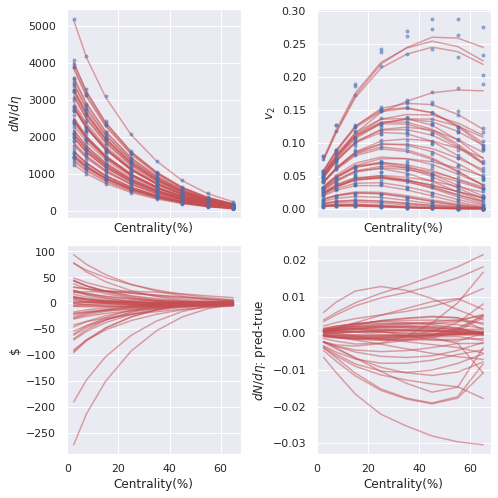

In [200]:
# Next, get the emulator prediction and uncertainty
Y_predicted = []
Y_std = []
for param in X_validation:
    mean, var = predict_observables(param)
    Y_predicted.append(mean[0])
    Y_std.append(np.sqrt(np.diag(var)))
Y_predicted = np.array(Y_predicted)
Y_std = np.array(Y_std)
fig, axes = plt.subplots(2,2, figsize=(7,7), sharex=True)
for it, y0 in zip(Y_predicted, Y_validation):
    axes[0,0].plot(cen,it[:Nc],color='r',alpha=.5)
    axes[0,1].plot(cen,it[Nc:],color='r',alpha=.5)
    axes[0,0].plot(cen,y0[:Nc],'b.',alpha=.5)
    axes[0,1].plot(cen,y0[Nc:],'b.',alpha=.5)
    
    axes[1,0].plot(cen,it[:Nc]-y0[:Nc],color='r',alpha=.5)
    axes[1,1].plot(cen,it[Nc:]-y0[Nc:],color='r',alpha=.5)
    #axes[1,0].set_ylim(0,2)
   # axes[1,1].set_ylim(0,2)

labels = r"$dN/d\eta$", r"$v_2$", r"$", r"$dN/d\eta$: pred-true", r"$v_2$: pred-true"
for ax, label in zip(axes.flatten(), labels):
    ax.set_xlabel("Centrality(%)")
    ax.set_ylabel(label)
plt.tight_layout(True)

Text(0, 0.5, 'P(d)')

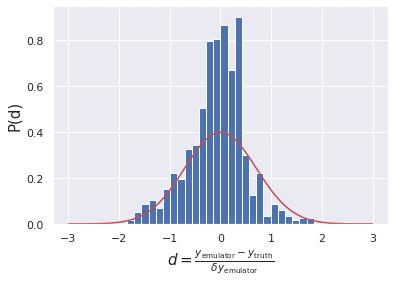

In [201]:
# A self-normalized check
normalized_discrepancy = ((Y_predicted - Y_validation)/Y_std).flatten()
_ = plt.hist(normalized_discrepancy, bins=31, density=True)
x = np.linspace(-3,3,101)
plt.plot(x, np.exp(-x**2)/np.sqrt(2*np.pi),'r-')
plt.xlabel(r"$d=\frac{y_{\rm emulator}-y_{\rm truth}}{\delta y_{\rm emulator}}$", fontsize=15)
plt.ylabel(r"P(d)", fontsize=15)

### 5. Bayesian parameter inference

In [202]:
def log_prior(model_parameters):
    """Evaluvate the prior at model prameter values. 
    If all parameters are inside bounds function will return 0 otherwise -inf"""
    X = np.array(model_parameters).reshape(1,-1)
    lower = np.all(X >= design_min)
    upper = np.all(X <= design_max)
    if (lower and upper):
        lp=0
    # lp = np.log(st.beta.pdf(X,5,1,dsgn_min_ut.reshape(1,-1),(dsgn_max_ut-dsgn_min_ut).reshape(1,-1))).sum()
    else:
        lp = -np.inf
    return lp
# >>> note informative prior

In [203]:
def mvn_loglike(y, cov):
    """
    Evaluate the multivariate-normal log-likelihood for difference vector `y`
    and covariance matrix `cov`:

        log_p = -1/2*[(y^T).(C^-1).y + log(det(C))] + const.

    The likelihood is NOT NORMALIZED, since this does not affect MCMC.  The
    normalization const = -n/2*log(2*pi), where n is the dimensionality.

    Arguments `y` and `cov` MUST be np.arrays with dtype == float64 and shapes
    (n) and (n, n), respectively.  These requirements are NOT CHECKED.

    The calculation follows algorithm 2.1 in Rasmussen and Williams (Gaussian
    Processes for Machine Learning).

    """
    # Compute the Cholesky decomposition of the covariance.
    # Use bare LAPACK function to avoid scipy.linalg wrapper overhead.
    L, info = lapack.dpotrf(cov, clean=False)

    if info < 0:
        raise ValueError(
            'lapack dpotrf error: '
            'the {}-th argument had an illegal value'.format(-info)
        )
    elif info < 0:
        raise np.linalg.LinAlgError(
            'lapack dpotrf error: '
            'the leading minor of order {} is not positive definite'
            .format(info)
        )

    # Solve for alpha = cov^-1.y using the Cholesky decomp.
    alpha, info = lapack.dpotrs(L, y)

    if info != 0:
        raise ValueError(
            'lapack dpotrs error: '
            'the {}-th argument had an illegal value'.format(-info)
         )

    if np.all(L.diagonal()>0):
        return -.5*np.dot(y, alpha) - np.log(L.diagonal()).sum()
    else:
        return -.5*np.dot(y, alpha) - np.log(np.abs(L.diagonal())).sum()
        print(L.diagonal())
        raise ValueError(
            'L has negative values on diagonal {}'.format(L.diagonal())
        )

In [204]:
# Covariance truncation error from PC is not yet included
def log_posterior(model_parameters):
    mn, var = predict_observables(model_parameters)
    delta_y = mn - y_exp.reshape(1,-1)
    delta_y = delta_y.flatten()   
    total_var = var + y_exp_variance
    return log_prior(model_parameters) + mvn_loglike(delta_y,total_var)

In [205]:
#log_posterior(MAP_params['Pb-Pb-2760'])
print(emcee.__version__)

3.0.2


In [ ]:
do_mcmc = True

Burn=True
from multiprocessing import Pool
ndim = Xdim  # number of parameters in the model
nwalkers = 10*Xdim  # number of MCMC walkers
nburn = 500 # "burn-in" period to let chains stabilize
nsteps = 2000  # number of MCMC steps to take
filename = data_path(name+".h5")

if do_mcmc==True:
    #backend = emcee.backends.HDFBackend(filename)
    starting_guesses = design_min + (design_max - design_min) * np.random.rand(nwalkers, ndim)
    #print(starting_guesses)
    print("MCMC sampling using emcee (affine-invariant ensamble sampler) with {0} walkers".format(nwalkers))
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)#, pool=pool, backend=backend)
        if Burn==True:
            print('burn in sampling started')    
            #backend.reset(nwalkers, ndim)
            print('burn was true, going to burnin')
            pos = sampler.run_mcmc(starting_guesses, nburn, progress=True, store=True)
            print("Mean acceptance fraction: {0:.3f} (in total {1} steps)".format(
                        np.mean(sampler.acceptance_fraction), nwalkers*nburn))
            print('Burn in completed.')
        print("Now running the samples")
        sampler.run_mcmc(initial_state=None, nsteps=nsteps, progress=True, tune=False)  
        print("Mean acceptance fraction: {0:.3f} (in total {1} steps)".format(
                        np.mean(sampler.acceptance_fraction), nwalkers*nsteps))
        
        # discard burn-in points and flatten the walkers; the shape of samples is (nwalkers*nsteps, ndim)
        #samples = backend.get_chain(flat=True, discard=nburn)
        samples = sampler.get_chain(flat=True, discard=nburn)
        samples_df = pd.DataFrame(samples, columns=model_param_dsgn)
        samples_df.to_csv(data_path('ChainForSImpleModel'), index=False)
else:
    #df1=h5py.File(filename,mode='r')
    print('Loading chain from disk')
    samples_df=pd.read_csv(data_path('ChainForSImpleModel'))
    samples= samples_df.values

MCMC sampling using emcee (affine-invariant ensamble sampler) with 50 walkers


  0%|          | 0/500 [00:00<?, ?it/s]

burn in sampling started
burn was true, going to burnin


  0%|          | 3/2000 [00:00<01:19, 25.19it/s]

Mean acceptance fraction: 0.270 (in total 25000 steps)
Burn in completed.
Now running the samples


 75%|███████▍  | 1493/2000 [00:48<00:15, 31.76it/s]

In [ ]:
samples_df.head()
samples_df.shape

#### Find MAP

In [ ]:
find_map_param = True
if find_map_param == True:
    bounds=[(a,b) for (a,b) in zip(design_min,design_max)]
    rslt = optimize.differential_evolution(lambda x: -log_posterior(x), 
                                           bounds=bounds,
                                          #disp=True,
                                          tol=1e-9,
                                         )
    print(rslt.x)

In [ ]:
map_values_saved = rslt.x

In [ ]:
#np.divide(map_values_saved,MAP_params['Pb-Pb-2760'])

In [ ]:
sns.color_palette('bright')

In [ ]:
map_parameters = map_values_saved.flatten()
g = sns.PairGrid(samples_df.iloc[:,:], corner=True, diag_sharey=False)
g.map_lower(sns.histplot, bins=100, color=sns.color_palette()[0])
g.map_diag(sns.kdeplot, linewidth=2, shade=True, color=sns.color_palette()[-1])
for n in range(Xdim):
    ax=g.axes[n][n]
    ax.axvline(x=map_parameters[n], ls='--', c=sns.color_palette()[9], label='MAP')
    ax.axvline(x=true_values[n], ls='-', c=sns.color_palette()[3], label='Truth')
    ax.text(0,0.9,s= f'{map_parameters[n]:.2f}', transform=ax.transAxes, color=sns.color_palette()[9], fontsize=12)
    ax.text(0,0.8,s= f'{true_values[n]:.2f}', transform=ax.transAxes, color=sns.color_palette()[3], fontsize=12)
g.axes[1,1].legend(loc='best', fontsize=10)
for i in range(Xdim):
    for j in range(i+1):
        g.axes[i,j].set_xlim(*ranges[j])
        if i==j:
            g.axes[i,j].set_ylim(*ranges[i])
            
        else:
            g.axes[i,j].set_ylim(ymax=0)
plt.tight_layout()
save_fig(name+"partial")
plt.show()

In [ ]:
Tt = np.linspace(0.13, 0.6, 100)
Nsamples = 10000
Nthin = samples_df.size//Nsamples
# prior samples of eta/s(T)
prior_etas = np.array([
        etas(Tt, row[1:]) for row in ((ranges[:,1]-ranges[:,0])*np.random.rand(Nsamples,Xdim)+ranges[:,0])
])
# posterior samples of eta/s(T)
posterior_etas = np.array([
        etas(Tt, row[1:]) for row in samples_df.iloc[::Nthin,:].values
])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,5),
                      sharex=False, sharey=False, 
                      constrained_layout=True)
fig.suptitle("Posterior v.s. Prior", wrap=True)

# plot posterior, display 30%, 60%, and 90% credible limits
CLbins = [30,60,90]
for CL, opacity in zip(CLbins, [.8,.6,.4]):
    lower, upper = np.percentile(posterior_etas, [50-CL/2., 50+CL/2.], axis=0)
    ax.fill_between(Tt,lower, upper,color=sns.color_palette()[1], alpha=opacity, label='{:d}% Posterior'.format(CL))
    
# plot prior, display 30%, 60%, 90%, and 100% credible limits
CLbins = [30,60,90,100]
for CL, opacity in zip(CLbins, [.25,.2,.15,.1]):
    lower, upper = np.percentile(prior_etas, [50-CL/2., 50+CL/2.], axis=0)
    ax.fill_between(Tt,lower, upper,color=sns.color_palette()[0], alpha=opacity, label='{:d}% Prior'.format(CL))

ax.plot(Tt, etas(Tt, true_values[1:]),'-', color=plt.cm.Reds(.4), lw=3, label='Truth')
ax.plot(Tt, etas(Tt, map_parameters[1:]),'--', color=plt.cm.Blues(.4), lw=3, label='MAP')

ax.legend(loc='upper left', ncol=2)
ax.set_ylim(0,.8)
ax.set_xlabel('T [GeV]')
ax.set_ylabel('$\eta/s$')
save_fig('shear_simple_model')

Finally, it is always important to check if the observables are well described.
It is possible that a poorly performing model produce a tightly-constrained posterior.

In [ ]:
Nsamples = 1000
Nthin = samples_df.size//Nsamples
# prior parameter samples
prior_params = (ranges[:,1]-ranges[:,0])*np.random.rand(Nsamples,Xdim) + ranges[:,0]
# posterior parameter samples 
posterior_params =  samples_df.iloc[::Nthin,:].values

prior_obs = [predict_observables(p)[0][0] for p in prior_params]
posterior_obs = [predict_observables(p)[0][0] for p in posterior_params]


#### Define temperature dependent viscosity functions

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(6,6), sharex=True)
Nc = len(cen)
# plot posterior, display 30%, 60%, and 90% credible limits
CLbins = [30,60,90]
for CL, opacity in zip(CLbins, [.8,.6,.4]):
    lower, upper = np.percentile(posterior_obs, [50-CL/2., 50+CL/2.], axis=0)
    axes[0,0].fill_between(cen, lower[:Nc], upper[:Nc], color=sns.color_palette()[1], 
                        alpha=opacity, label='{:d}% Posterior'.format(CL))
    axes[0,1].fill_between(cen, lower[Nc:], upper[Nc:], color=sns.color_palette()[1], 
                        alpha=opacity, label='{:d}% Posterior'.format(CL)) 
    axes[1,0].fill_between(cen, lower[:Nc]/Mult, upper[:Nc]/Mult, color=sns.color_palette()[1], 
                        alpha=opacity, label='{:d}% Posterior'.format(CL))
    axes[1,1].fill_between(cen, lower[Nc:]/v2, upper[Nc:]/v2, color=sns.color_palette()[1], 
                        alpha=opacity, label='{:d}% Posterior'.format(CL)) 
# plot prior, display 30%, 60%, 90%, and 100% credible limits
CLbins = [30,60,90,100]
for CL, opacity in zip(CLbins, [.25,.2,.15,.1]):
    lower, upper = np.percentile(prior_obs, [50-CL/2., 50+CL/2.], axis=0)
    axes[0,0].fill_between(cen, lower[:Nc], upper[:Nc], color=sns.color_palette()[0], 
                        alpha=opacity, label='{:d}% Prior'.format(CL))
    axes[0,1].fill_between(cen, lower[Nc:], upper[Nc:], color=sns.color_palette()[0], 
                        alpha=opacity, label='{:d}% Prior'.format(CL)) 
    axes[1,0].fill_between(cen, lower[:Nc]/Mult, upper[:Nc]/Mult, color=sns.color_palette()[0], 
                        alpha=opacity, label='{:d}% Prior'.format(CL))
    axes[1,1].fill_between(cen, lower[Nc:]/v2, upper[Nc:]/v2, color=sns.color_palette()[0], 
                        alpha=opacity, label='{:d}% Prior'.format(CL)) 
    
for ax,y,name in zip(axes[0], 
                    [Mult, v2],
                    [r"$N_{\rm ch}$", r"$v_2$"]):
    ax.errorbar(cen, y, yerr=y*.05, fmt='k.')
    ax.set_ylabel(name)
    ax.set_xlabel("Centrality (%)")
    
for ax,y,name in zip(axes[1], 
                    [Mult, v2],
                    ["Ratio to pseudo-data$"]*2):
    ax.errorbar(cen, y/y, yerr=y/y*.05, fmt='k.')
    ax.set_ylabel(name)
    ax.set_xlabel("Centrality (%)")
axes[0,0].semilogy()
axes[0,1].semilogy()
axes[1,0].set_ylim(0,2)
axes[1,1].set_ylim(0,2)
plt.tight_layout(True)

# To do list
> Emulator validation

> Closure tests

> Observable predictions from MAP

> Including other systems in the parameter estimation

> Tests for MCMC convergence

> Bayesian evidence calculation

> Repeat the Analysis for different model choices

> Bayesian Model Averaging
